In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [3]:
spark = SparkSession.builder.appName("proj").getOrCreate()

In [4]:
spark

In [5]:
!hadoop fs -ls /dsets/pollution/

Found 1 items
-rw-r--r--   1 hadoop supergroup   97756504 2022-03-31 12:09 /dsets/pollution/pollution_2000_2021.csv


In [6]:
df = spark.read.csv("/dsets/pollution/pollution_2000_2021.csv", header=True, inferSchema=True)

## shape of the dataset

In [7]:
f"This dataset has {df.count()} rows and {len(df.columns)} columns."

'This dataset has 608699 rows and 24 columns.'

## check schema

In [8]:
df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- Address: string (nullable = true)
 |-- State: string (nullable = true)
 |-- County: string (nullable = true)
 |-- City: string (nullable = true)
 |-- O3 Mean: double (nullable = true)
 |-- O3 1st Max Value: double (nullable = true)
 |-- O3 1st Max Hour: integer (nullable = true)
 |-- O3 AQI: integer (nullable = true)
 |-- CO Mean: double (nullable = true)
 |-- CO 1st Max Value: double (nullable = true)
 |-- CO 1st Max Hour: integer (nullable = true)
 |-- CO AQI: double (nullable = true)
 |-- SO2 Mean: double (nullable = true)
 |-- SO2 1st Max Value: double (nullable = true)
 |-- SO2 1st Max Hour: integer (nullable = true)
 |-- SO2 AQI: double (nullable = true)
 |-- NO2 Mean: double (nullable = true)
 |-- NO2 1st Max Value: double (nullable = true)
 |-- NO2 1st Max Hour: integer (nullable = true)
 |-- NO2 AQI: integer (nullable = tr

## count of null values

In [9]:
df[[F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]].show()

+----+----+-----+---+-------+-----+------+----+-------+----------------+---------------+------+-------+----------------+---------------+------+--------+-----------------+----------------+-------+--------+-----------------+----------------+-------+
|Date|Year|Month|Day|Address|State|County|City|O3 Mean|O3 1st Max Value|O3 1st Max Hour|O3 AQI|CO Mean|CO 1st Max Value|CO 1st Max Hour|CO AQI|SO2 Mean|SO2 1st Max Value|SO2 1st Max Hour|SO2 AQI|NO2 Mean|NO2 1st Max Value|NO2 1st Max Hour|NO2 AQI|
+----+----+-----+---+-------+-----+------+----+-------+----------------+---------------+------+-------+----------------+---------------+------+--------+-----------------+----------------+-------+--------+-----------------+----------------+-------+
|   0|   0|    0|  0|      0|    0|     0|   0|      0|               0|              0|     0|      0|               0|              0|     0|       0|                0|               0|      0|       0|                0|               0|      0|
+----+--

## check dtypes

In [10]:
df.dtypes

[('Date', 'string'),
 ('Year', 'int'),
 ('Month', 'int'),
 ('Day', 'int'),
 ('Address', 'string'),
 ('State', 'string'),
 ('County', 'string'),
 ('City', 'string'),
 ('O3 Mean', 'double'),
 ('O3 1st Max Value', 'double'),
 ('O3 1st Max Hour', 'int'),
 ('O3 AQI', 'int'),
 ('CO Mean', 'double'),
 ('CO 1st Max Value', 'double'),
 ('CO 1st Max Hour', 'int'),
 ('CO AQI', 'double'),
 ('SO2 Mean', 'double'),
 ('SO2 1st Max Value', 'double'),
 ('SO2 1st Max Hour', 'int'),
 ('SO2 AQI', 'double'),
 ('NO2 Mean', 'double'),
 ('NO2 1st Max Value', 'double'),
 ('NO2 1st Max Hour', 'int'),
 ('NO2 AQI', 'int')]

## fix date column

In [11]:
df = df.withColumn("Date", df['Date'].cast("date"))

## clean long city name

In [12]:
df = df.withColumn("City", 
              F.when(F.col("City") == 'Calumet City (PU RR name Calumet Park (sta.))', 
                   'Calumet City').otherwise(F.col("City")))

## date range of the dataset

In [13]:
df.agg(F.min('Date'), F.max('Date')).show()

+----------+----------+
| min(Date)| max(Date)|
+----------+----------+
|2000-01-01|2021-10-31|
+----------+----------+



## get number of states and cities

In [13]:
df.agg(F.countDistinct("State"), F.countDistinct("City")).show()

+------------+-----------+
|count(State)|count(City)|
+------------+-----------+
|          48|        148|
+------------+-----------+



## count of states in the dataset

In [14]:
state_counts = df.groupby("State").count()

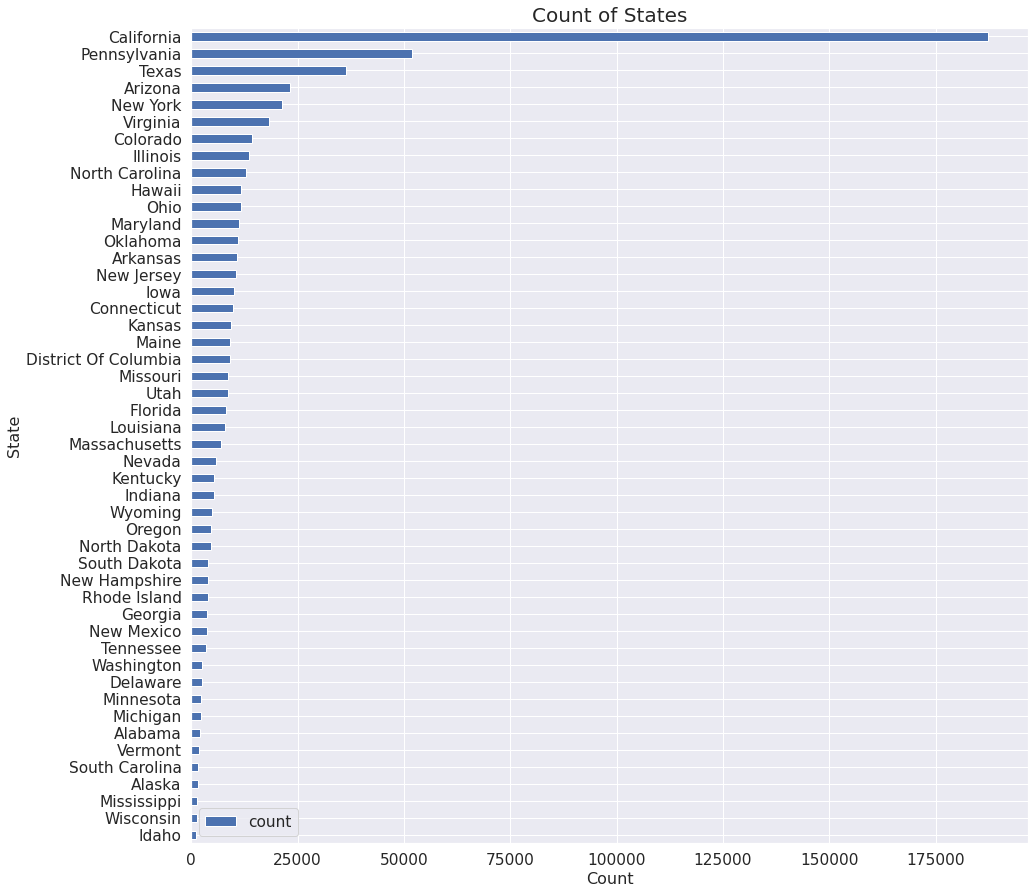

In [15]:
ax = state_counts.toPandas().sort_values(by="count").plot(kind='barh', x="State",  figsize=(15,15))

ax.set_ylabel("State", fontsize=16)
ax.set_xlabel("Count", fontsize=16)
ax.set_title('Count of States', fontsize=20)

plt.savefig('assets/plots/state_counts.jpeg', bbox_inches='tight')

## macro trend of pollutants

In [14]:
aqi_cols = ['SO2 AQI', 'CO AQI', 'NO2 AQI', 'O3 AQI']

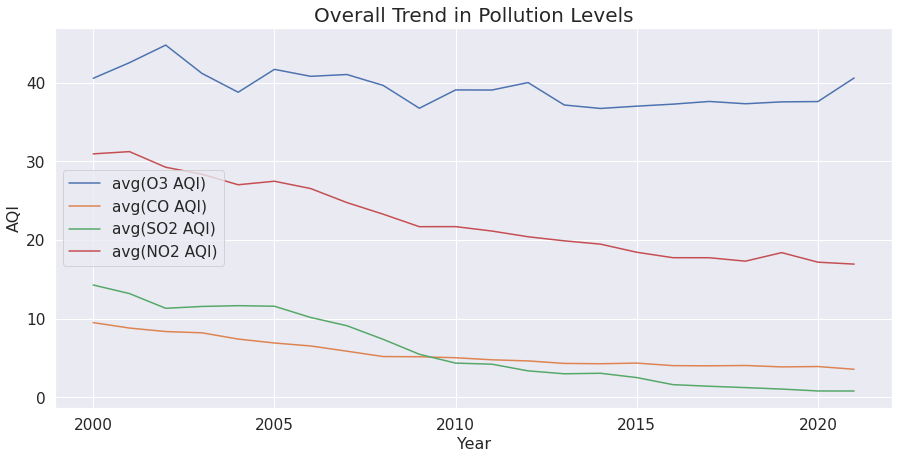

In [17]:
macro_pollutants = df.groupby('Year').agg({x: "mean" for x in aqi_cols}).orderBy('Year')
ax = macro_pollutants.toPandas().set_index('Year').plot(figsize=(15,7))

ax.set_ylabel("AQI", fontsize=16)
ax.set_xlabel("Year", fontsize=16)
ax.set_title('Overall Trend in Pollution Levels', fontsize=20)

plt.savefig('assets/plots/overall-trend.jpeg', bbox_inches='tight')

## most polluted cities

In [18]:
def max_polluted_city(pollutant):
    x1 = (df.groupby('City')
          .agg(F.round(F.mean(pollutant), 2).alias(pollutant))
          .orderBy(pollutant, ascending=False)
          .toPandas())
    return x1[:10].style.background_gradient(cmap='OrRd')

In [19]:
#source: https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.render()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [20]:
no2 = max_polluted_city('NO2 Mean')
so2 = max_polluted_city('SO2 Mean')
co = max_polluted_city('CO Mean')
o3 = max_polluted_city('O3 Mean')


display_side_by_side(no2,so2,co,o3)

,City,NO2 Mean
0,Chicago,31.450000
1,Burbank,30.430000
2,Bakersfield,29.020000
3,Hawthorne,24.990000
4,West Los Angeles,23.780000
5,Scottsdale,22.620000
6,Long Beach,22.070000
7,Calumet City,21.780000
8,Cicero,21.260000
9,Ladue,21.090000


## correlation between features

In [21]:
pollutants = ["SO2 Mean", "CO Mean", "NO2 Mean", "O3 Mean"]

In [22]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=pollutants, outputCol=vector_col)
df_vector = assembler.transform(df).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]

In [23]:
corrmatrix = matrix.toArray().tolist()
corr_pd = pd.DataFrame(corrmatrix, columns=pollutants, index=pollutants)

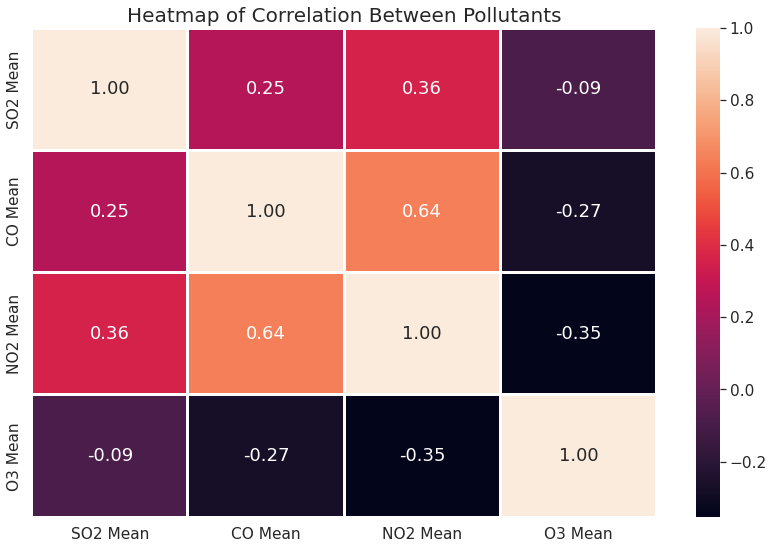

In [24]:
plt.figure(figsize=(14, 9))

sns.heatmap(corr_pd, annot=True, fmt='.2f', annot_kws={"size": 18}, linewidths=2)
plt.title('Heatmap of Correlation Between Pollutants', fontsize=20)

plt.savefig('assets/plots/corr-heatmap.jpeg', bbox_inches='tight')

## pollution in 6 most populated cities in 2021

In [25]:
famous_cities = ["New York", "Los Angeles", "Chicago", "Houston", "Philadelphia", "San Antonio"]
famous_df = df[(df.City.isin(famous_cities)) & (df['Year'] == 2021)][["City"] + aqi_cols]

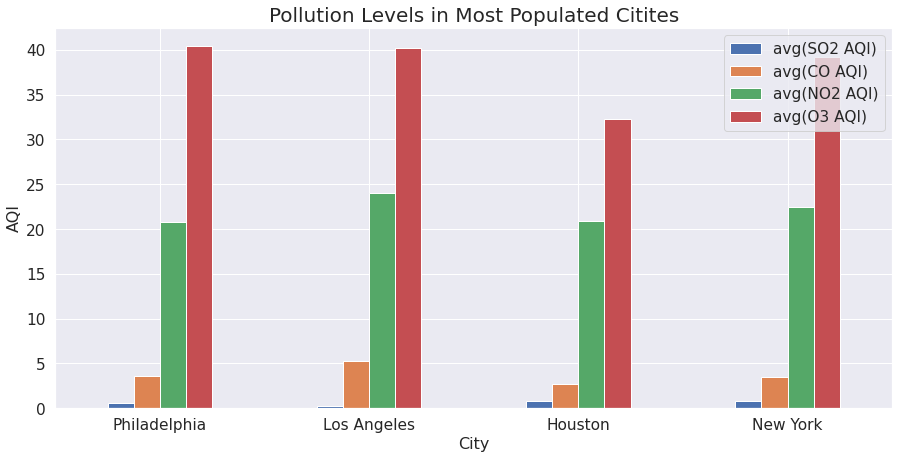

In [26]:
ax = famous_df.groupby("City").mean().toPandas().plot(kind='bar', x='City', figsize=(15, 7), rot=0)

ax.set_ylabel("AQI", fontsize=16)
ax.set_xlabel("City", fontsize=16)
ax.set_title('Pollution Levels in Most Populated Citites', fontsize=20)

plt.savefig('assets/plots/most-populated-cities.jpeg', bbox_inches='tight')

# Thank You